# Stack overflow 2017 survey analysis

As a senior developer, satisfied of his career and job, I would like to focus on these two points by replying to this questions:
1. Which are the jobs that statisfied the most the repliers?
2. In which countries are located the most?
3. What are the main caracteristics of a satisfying job?

In [1]:
%%capture
!pip install pandas plotly_express pycountry pycountry-convert networkx

import pandas as pd
import pycountry
import pycountry_convert

pd.options.display.max_columns = None

In [2]:
%%capture
def get_country_continent_data(country_name):
    country_alpha2 = None
    country_alpha3 = None
    country_continent_code = None
    country_continent_name = None
    try:
        country_alpha2 = pycountry_convert.country_name_to_country_alpha2(country_name)
        country_alpha3 = pycountry_convert.country_name_to_country_alpha3(country_name)
        country_continent_code = pycountry_convert.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pycountry_convert.convert_continent_code_to_continent_name(country_continent_code)
    except:
        None
    return pd.Series([country_alpha2, country_alpha3, country_continent_name, country_continent_code])

raw_df = pd.read_csv('developer_survey_2017/survey_results_public.csv')
country_meta = raw_df.Country.apply(lambda x: get_country_continent_data(x))
df = raw_df.assign(CountryCodeAlpha2 = country_meta[0], CountryCodeAlpha3 = country_meta[1], Continent = country_meta[2], ContinentCode = country_meta[3])

schema_df = pd.read_csv('developer_survey_2017/survey_results_schema.csv')

In [3]:
%%capture
def get_column_values_counts(df, column_name, separator=None):
    """
        Get the count of the different values of a given column in the given dataframe.
        If a separator is given, the values will be splitted according to the given separator.
        
        :param df: The source dataframe
        :param column_name: The name of the column values are wanted
        :param separator: THe separator used to split values (optional)
        :type df: object
        :type column_name: string
        :type separator: string|None
        :return: The dataframe containing every values of the column in the `column_name` column and the count in a "Count" column
        :rtype: object
    """
    not_null_df = df[df[column_name].notnull()]
    values_series = not_null_df[column_name]
    if separator != None:
        values_series = values_series.str.split("; ", expand = True).stack()
    return values_series.value_counts().to_frame(name="Count").reset_index().rename(columns={'index': column_name})

## Audience

Before diving into the numbers, let's see what the audience looks like.

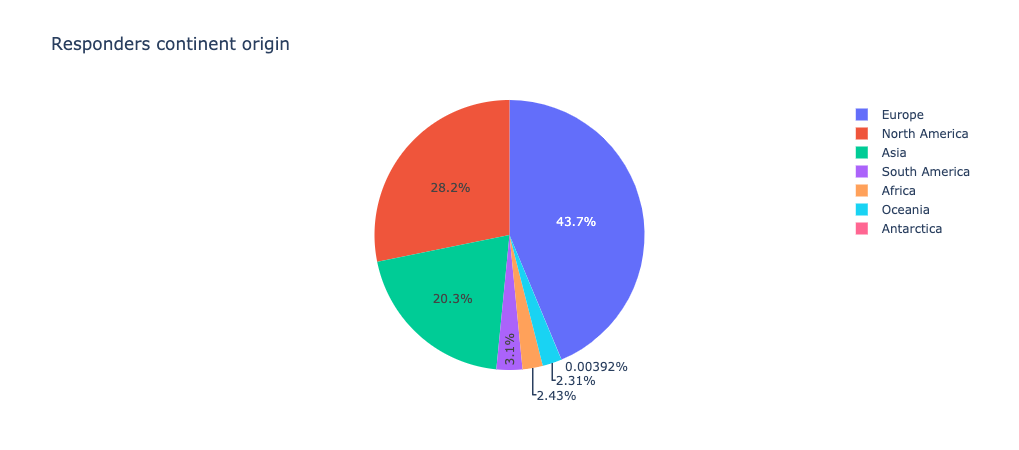

In [4]:
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

continent_df = get_column_values_counts(df, "Continent")

fig_continent = px.pie(continent_df, values="Count", names="Continent", title="Responders continent origin")
fig_continent.show()

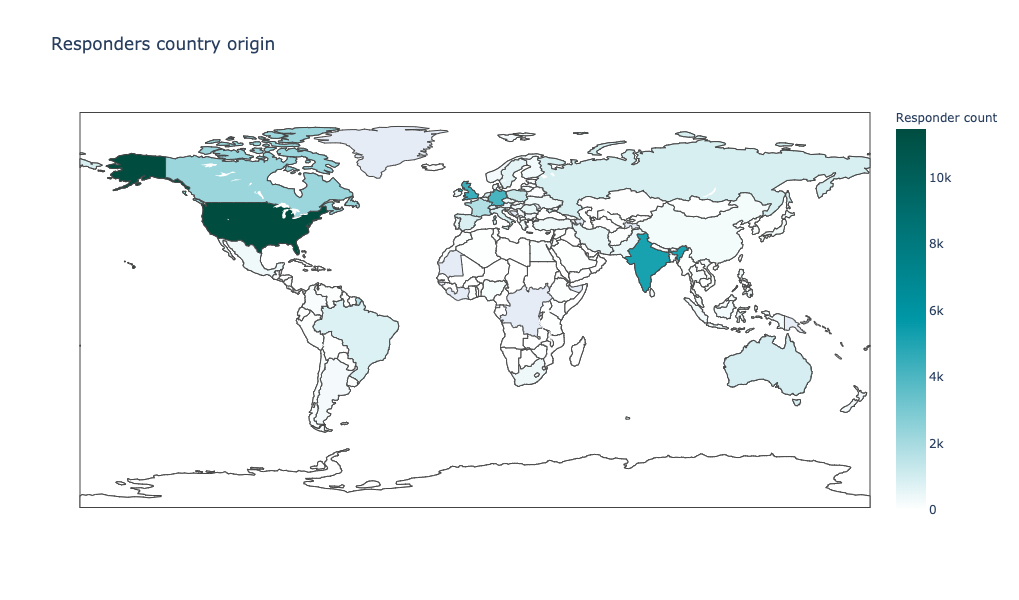

In [5]:
count_by_country_df = df.CountryCodeAlpha3.value_counts().to_frame(name="Count").reset_index().rename(columns={'index': 'CountryCode'})
country_name = count_by_country_df.CountryCode.apply(lambda x: pycountry.countries.get(alpha_3=x).name if pycountry.countries.get(alpha_3=x) else None)
count_by_country_df = count_by_country_df.assign(Country = country_name)
audience_origin_fig = px.choropleth(count_by_country_df, locations = "CountryCode", color="Count",
                    hover_name="Country", color_continuous_scale=["white", "#0097a7", "#004d40"],
                    labels={'Count':'Responder count'}, title="Responders country origin", height=600)
audience_origin_fig.show()

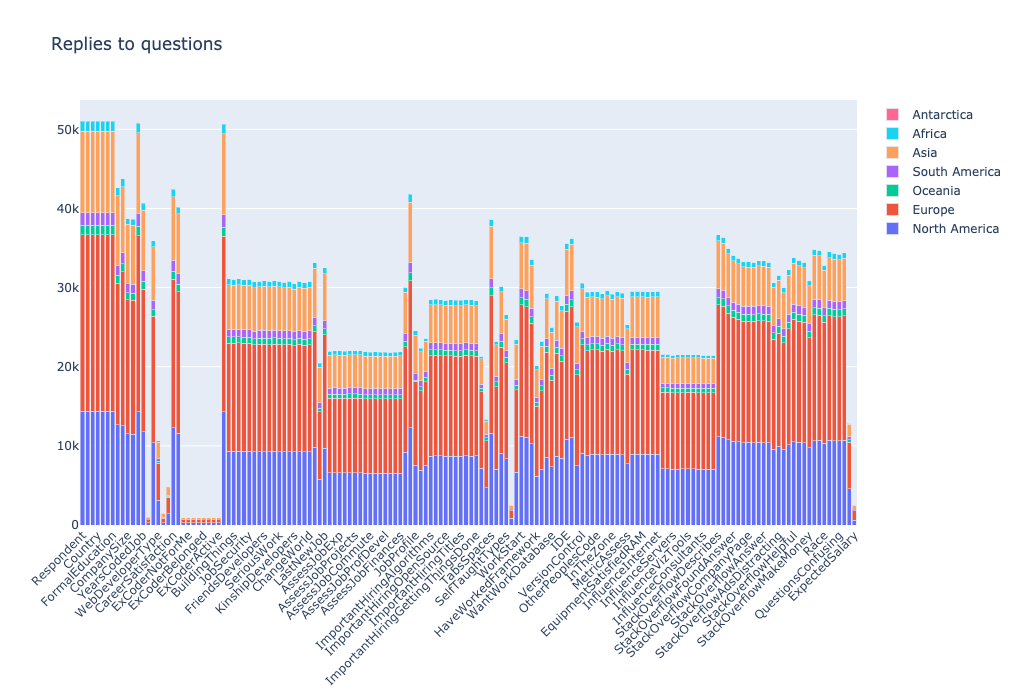

In [6]:
import plotly.graph_objects as go

figures = []
for continent in df.Continent.unique():
    if continent != None:
        continent_df = df[df.Continent == continent].notnull().drop(columns=["CountryCodeAlpha2", "CountryCodeAlpha3", "Continent", "ContinentCode"]).sum(axis=0).to_frame(name="Sum").reset_index().rename(columns={'index': 'Question'})
        figures.append(go.Bar(name=continent, x=continent_df.Question, y=continent_df.Sum))

fig_replies_questions = go.Figure(data=figures)
fig_replies_questions.update_layout(barmode='stack', title="Replies to questions", height=700,xaxis_tickangle=-45)
fig_replies_questions.show()

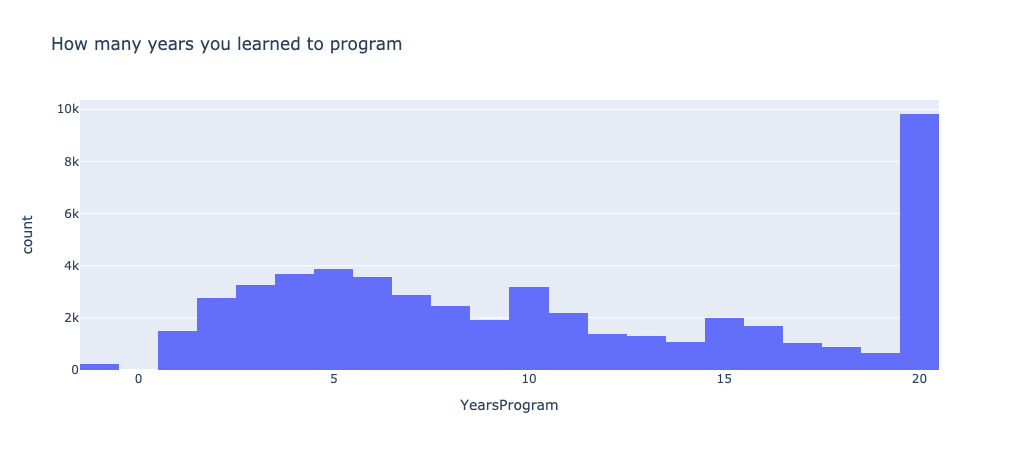

In [7]:
years_program_df = df.YearsProgram.to_frame(name="YearsProgram")
clean_years_program_df = years_program_df.replace(to_replace=r'^\d+\sto\s(\d+).*$', value='\\1', regex=True).replace(to_replace = "20 or more years", value = 20).replace(to_replace = "Less than a year", value = 1).fillna(-1)

fig_years_to_program = px.histogram(clean_years_program_df, x="YearsProgram", title="How many years you learned to program")
fig_years_to_program.show()

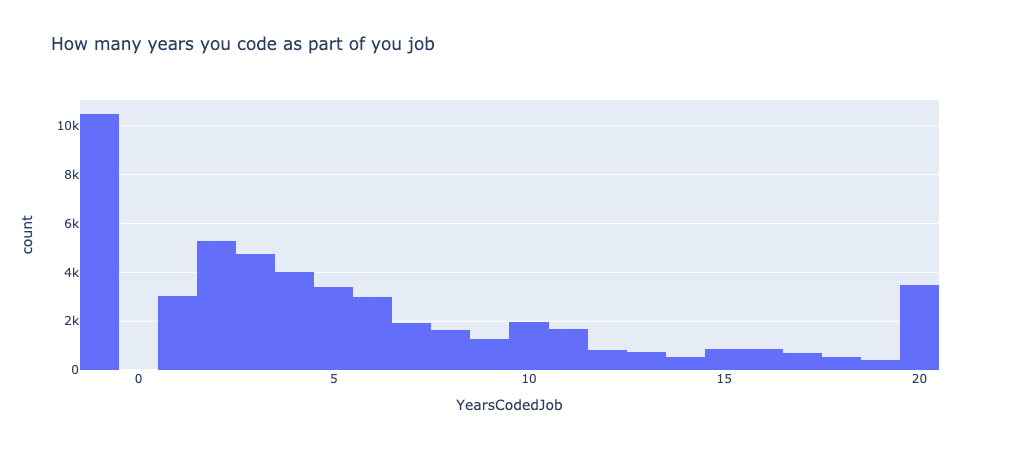

In [8]:
years_code_job_df = df.YearsCodedJob.to_frame(name="YearsCodedJob")
clean_years_code_job_df = years_code_job_df.replace(to_replace=r'^\d+\sto\s(\d+).*$', value='\\1', regex=True).replace(to_replace = "20 or more years", value = 20).replace(to_replace = "Less than a year", value = 1).fillna(-1)

fig_years_code_job = px.histogram(clean_years_code_job_df, x="YearsCodedJob", title="How many years you code as part of you job")
fig_years_code_job.show()

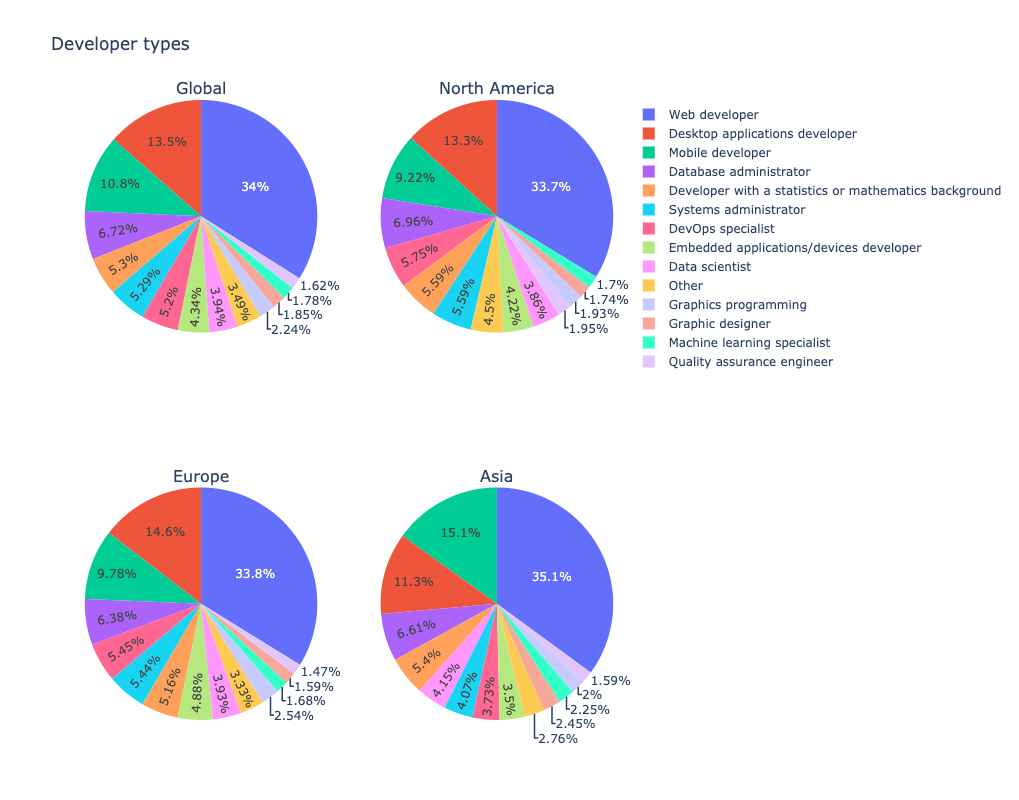

In [9]:
from plotly.subplots import make_subplots

global_developers_types_df = get_column_values_counts(df, "DeveloperType", "; ")
north_america_developers_types_df = get_column_values_counts(df[df.Continent == "North America"], "DeveloperType", "; ")
europe_developers_types_df = get_column_values_counts(df[df.Continent == "Europe"], "DeveloperType", "; ")
asia_developers_types_df = get_column_values_counts(df[df.Continent == "Asia"], "DeveloperType", "; ")

fig_compare = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "domain"}, {"type": "domain"}],
          [{"type": "domain"}, {"type": "domain"}]],
    subplot_titles=("Global","North America", "Europe", "Asia")
)
fig_compare.add_trace(
    go.Pie(values=global_developers_types_df.Count.tolist(), labels=global_developers_types_df.DeveloperType.tolist()),
        row=1,col=1
)
fig_compare.add_trace(
    go.Pie(values=north_america_developers_types_df.Count.tolist(), labels=north_america_developers_types_df.DeveloperType.tolist()),
    row=1,col=2
)
fig_compare.add_trace(
    go.Pie(values=europe_developers_types_df.Count.tolist(), labels=europe_developers_types_df.DeveloperType.tolist()),
    row=2,col=1
)
fig_compare.add_trace(
    go.Pie(values=asia_developers_types_df.Count.tolist(), labels=asia_developers_types_df.DeveloperType.tolist()),
    row=2,col=2
)
fig_compare.update_layout(height=800,title_text="Developer types")
fig_compare.show()

## The questions

> I will focus on job and career satisfaction. I will consider repliers as satisfied when their reply is over or 7, unsatisfied when reply is under 5.

### 1. Which are the jobs that statisfied the most the repliers?

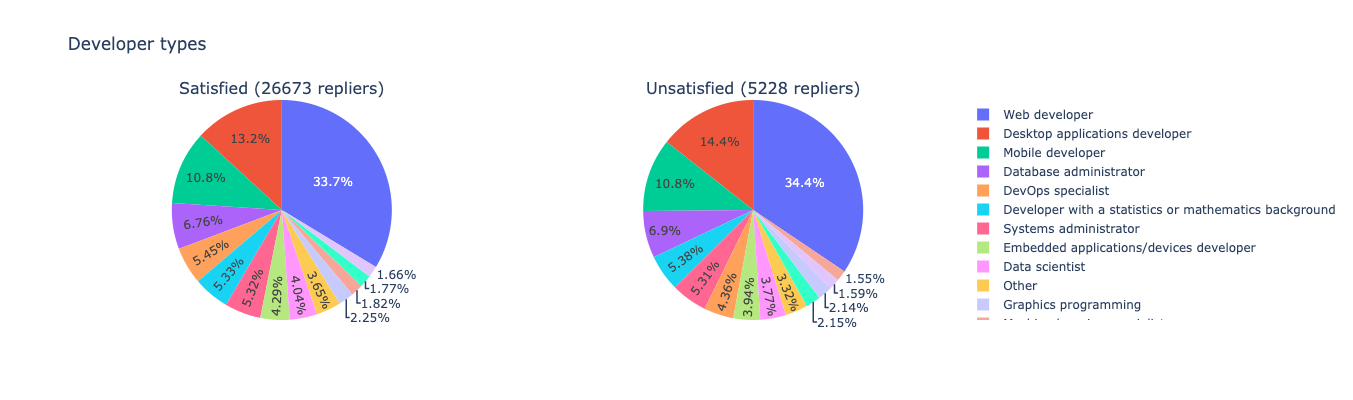

In [25]:
satisfied_df = df[df.JobSatisfaction >= 7.0]
unsatisfied_df = df[df.JobSatisfaction < 5.0]

developers_types_satisfied_df = get_column_values_counts(satisfied_df, "DeveloperType", "; ")
developers_types_unsatisfied_df = get_column_values_counts(unsatisfied_df, "DeveloperType", "; ")

fig_compare_satisfaction = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "domain"}, {"type": "domain"}]],
    subplot_titles=("Satisfied (" + str(satisfied_df.shape[0]) + " repliers)","Unsatisfied (" + str(unsatisfied_df.shape[0]) + " repliers)")
)
fig_compare_satisfaction.add_trace(
    go.Pie(values=developers_types_satisfied_df.Count.tolist(), labels=developers_types_satisfied_df.DeveloperType.tolist()),
        row=1,col=1
)
fig_compare_satisfaction.add_trace(
    go.Pie(values=developers_types_unsatisfied_df.Count.tolist(), labels=developers_types_unsatisfied_df.DeveloperType.tolist()),
    row=1,col=2
)
fig_compare_satisfaction.update_layout(height=400,title_text="Developer types")
fig_compare_satisfaction.show()